In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import requests
import tqdm
from time import sleep
from PIL import Image
from io import BytesIO
from adjustText import adjust_text
import nba_api

In [2]:
from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name
from nba_api.stats.endpoints.playerdashptshotdefend import PlayerDashPtShotDefend
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail

In [3]:
import random
from matplotlib.patches import Circle, Rectangle, Arc

# Amazing function by Bradley Fay for plotting the nba court
# source: https://github.com/bradleyfay/py-Goldsberry/blob/master/docs/Visualizing%20NBA%20Shots%20with%20py-Goldsberry.ipynb
def draw_court(ax=None, color='black', lw=2, background_color="#EBEBE8", outer_lines=False, zorder=None):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False, zorder=zorder)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color, zorder=zorder)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False, zorder=zorder)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False, zorder=zorder)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False, zorder=zorder)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed', zorder=zorder)
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color, zorder=zorder)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 138, linewidth=lw,
                               color=color, zorder=zorder)
    corner_three_b = Rectangle((220, -47.5), 0, 138, linewidth=lw, color=color, zorder=zorder)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22.13, theta2=157.87, linewidth=lw,
                    color=color, zorder=7)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color, zorder=zorder)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color, zorder=zorder)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]
    
    # Draw the half court line, baseline and side out bound lines
    outer_lines = Rectangle((-249, -48), 498, 470, linewidth=lw,
                            color=color, fill=None, zorder=7)
    court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

In [4]:
LESS_SIX = "LESS_THAN_SIX"
SIX_TEN = "SIX_TEN"
TEN_FIFTEEN = "TEN_FIFTEEN"
GREATER_FIFTEEN = "GREATER_FIFTEEN"
THREE_POINTER = "THREE_POINTER"

bball_gray = '#312f30'
bball_white = '#dddee0'
bball_orange = '#f87c24'
bball_light_orange = '#fbaf7b'


In [5]:
from matplotlib import patches
def plot_raw_shotchart(data_frame, title, label="Blocked Shot", team_id=None, player_id=None):
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(figsize=(12, 12))
    
    
    background_color=bball_gray
    font_color = bball_orange
    marker_color = bball_orange
    line_color = bball_light_orange
    edge_color = bball_white
    
    
    paths = ax.scatter(
        x=data_frame.LOC_X,
        y=data_frame.LOC_Y,
        marker='o',
        c=marker_color,
        s=180,
        zorder=1,
        lw=1,
        edgecolors=edge_color,
        label=label
    )

    
    # Removing ticks
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.grid(False)
    
    if player_id is not None:
        url = f"https://cdn.nba.com/headshots/nba/latest/260x190/{player_id}.png"
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))

        ax.imshow(img, extent=(132, 252, -48, 40))
    legend = ax.legend()
    frame = legend.get_frame()
    frame.set_facecolor(background_color)
    frame.set_linewidth(2)
    frame.set_edgecolor(bball_light_orange)
    for text in legend.get_texts():
        text.set_color(font_color)
        
    ax.text(250, -60, s="@daniel_bratulic", color=font_color, ha="right")
    
    ax.set_facecolor(background_color)
    fig.set_facecolor(background_color)
    ax.set_frame_on(False)
    
    # Title
    plt.title(title, size=26, color=font_color)
    
    # Drawing court
    draw_court(ax=ax,outer_lines=True, lw=3, color=line_color)
    ax.set_xlim(-251,251)
    ax.set_ylim(-65,423)
    

In [6]:
shot_chart = ShotChartDetail(team_id=0, player_id=0, season_nullable='2023-24', season_type_all_star='Pre Season', context_measure_simple='FGA')

In [29]:
shots_df = shot_chart.get_data_frames()[0]

In [9]:
wemby_id = find_players_by_full_name("Victor Wembanyama")[0]['id']

In [13]:
pbp_df = pd.read_csv('pbp_data/2023-24_preseason.csv')
pbp_df = pbp_df.fillna({
    "HOMEDESCRIPTION": "",
    "NEUTRALDESCRIPTION": "",
    "VISITORDESCRIPTION": ""
})
pbp_df.loc[:, 'GAME_ID'] = [f"00{item}" for item in pbp_df.GAME_ID.astype(str)]

In [15]:
shots_df.head()

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0012300001,7,1626157,Karl-Anthony Towns,1610612750,Minnesota Timberwolves,1,11,41,...,Left Side Center(LC),24+ ft.,27,-162,218,1,1,20231005,MIN,DAL
1,Shot Chart Detail,0012300001,30,203497,Rudy Gobert,1610612750,Minnesota Timberwolves,1,9,52,...,Center(C),Less Than 8 ft.,0,0,0,1,1,20231005,MIN,DAL
2,Shot Chart Detail,0012300001,35,1626157,Karl-Anthony Towns,1610612750,Minnesota Timberwolves,1,9,22,...,Center(C),Less Than 8 ft.,3,-6,36,1,1,20231005,MIN,DAL
3,Shot Chart Detail,0012300001,45,1629638,Nickeil Alexander-Walker,1610612750,Minnesota Timberwolves,1,8,51,...,Right Side(R),24+ ft.,24,227,78,1,1,20231005,MIN,DAL
4,Shot Chart Detail,0012300001,71,201144,Mike Conley,1610612750,Minnesota Timberwolves,1,7,18,...,Left Side Center(LC),24+ ft.,25,-162,194,1,1,20231005,MIN,DAL


In [16]:
pbp_df.head()

,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,...,PLAYER2_TEAM_ABBREVIATION,PERSON3TYPE,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ID,PLAYER3_TEAM_CITY,PLAYER3_TEAM_NICKNAME,PLAYER3_TEAM_ABBREVIATION,VIDEO_AVAILABLE_FLAG,PCTIMESECONDS
0,0012300066,2,12,0,1,7:11 PM,12:00,,Start of 1st Period (7:11 PM EST),,...,NaN,0,0,NaN,NaN,NaN,NaN,NaN,0,0
1,0012300066,4,10,0,1,7:11 PM,12:00,Jump Ball Turner vs. E. Mobley: Tip to Toppin,,,...,CLE,4,1630167,Obi Toppin,1.610613e+09,Indiana,Pacers,IND,1,0
2,0012300066,7,1,52,1,7:11 PM,11:46,Toppin 1' Alley Oop Dunk (2 PTS) (B. Brown 1 AST),,,...,IND,0,0,NaN,NaN,NaN,NaN,NaN,1,14
3,0012300066,9,1,3,1,7:12 PM,11:25,,,E. Mobley 5' Hook Shot (2 PTS),...,NaN,0,0,NaN,NaN,NaN,NaN,NaN,1,35
4,0012300066,10,2,75,1,7:12 PM,11:07,MISS Toppin 2' Driving Finger Roll Layup,,,...,NaN,0,0,NaN,NaN,NaN,NaN,NaN,1,53


In [30]:
merged_df = pd.merge(left=shots_df, right=pbp_df, left_on=['GAME_ID', 'GAME_EVENT_ID'], right_on=['GAME_ID', 'EVENTNUM'])

In [44]:
wemby_blocks = merged_df.loc[(merged_df.EVENTMSGTYPE == 2) & (merged_df.PLAYER3_ID == wemby_id)] 

In [49]:
team_id = wemby_blocks.iloc[0].TEAM_ID

In [50]:
team_id

1610612760

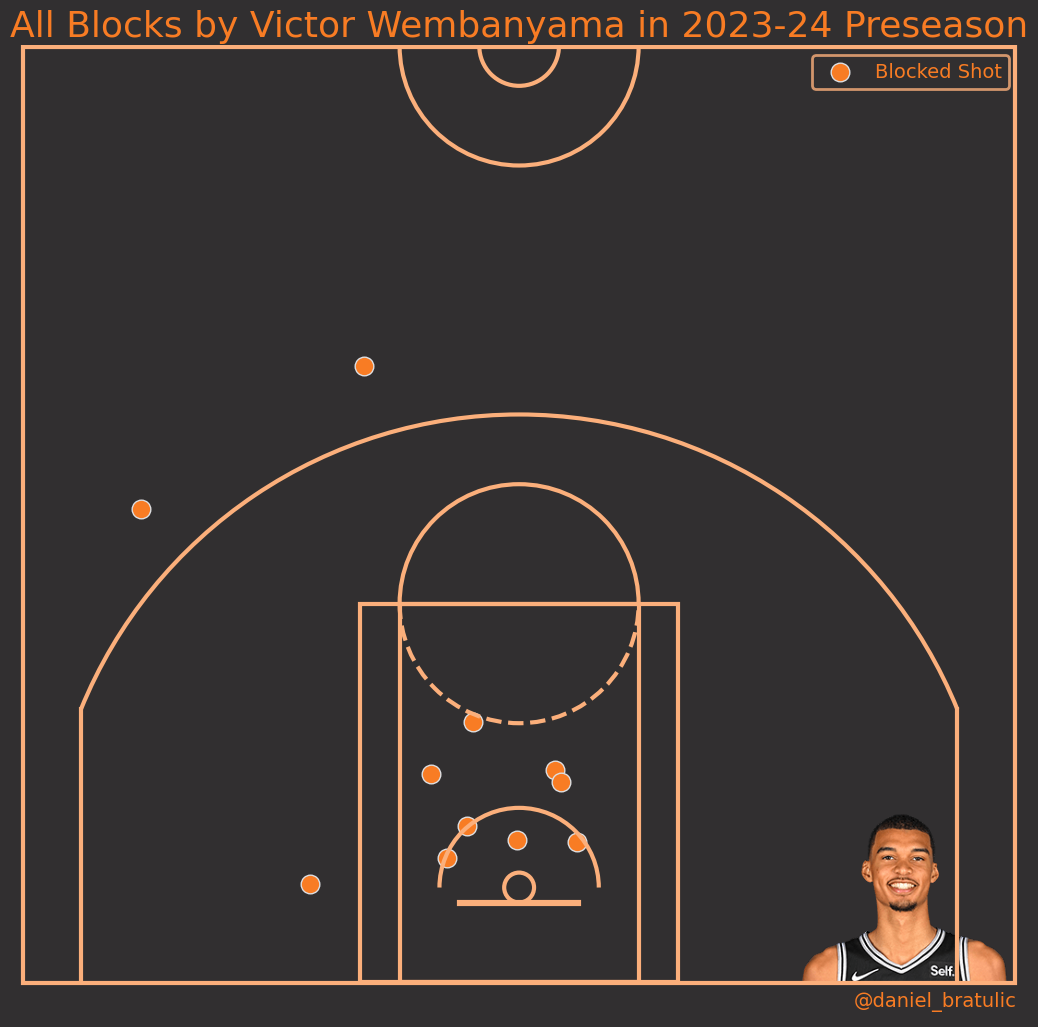

In [92]:
plot_raw_shotchart(data_frame=wemby_blocks, title='All Blocks by Victor Wembanyama in 2023-24 Preseason', team_id=team_id, player_id=wemby_id)

## Last Season Totals

In [57]:
last_pbp_df = pd.read_csv('pbp_data/2022-23.csv')

In [58]:
last_pbp_df = last_pbp_df.fillna({
    "HOMEDESCRIPTION": "",
    "NEUTRALDESCRIPTION": "",
    "VISITORDESCRIPTION": ""
})
last_pbp_df.loc[:, 'GAME_ID'] = [f"00{item}" for item in last_pbp_df.GAME_ID.astype(str)]

In [59]:
last_shots_df = ShotChartDetail(team_id=0, player_id=0, context_measure_simple='FGA', season_nullable='2022-23').get_data_frames()[0]

In [60]:
last_merged = pd.merge(left=last_shots_df, right=last_pbp_df, left_on=['GAME_ID', 'GAME_EVENT_ID'], right_on=['GAME_ID', 'EVENTNUM'])

In [62]:
last_year_blocks = last_merged.loc[(last_merged.EVENTMSGTYPE == 2) & (last_merged.PLAYER3_ID != 0)]

In [68]:
last_year_blocks.value_counts('SHOT_ZONE_BASIC')

SHOT_ZONE_BASIC
Restricted Area          4761
In The Paint (Non-RA)    3374
Mid-Range                 439
Above the Break 3         363
Right Corner 3             77
Left Corner 3              69
Backcourt                   5
Name: count, dtype: int64

In [ ]:
last_merged.SHOT_ATTEMPTED_FLAG

In [79]:
last_merged.SHOT_ZONE_BASIC

0                     Mid-Range
1                     Mid-Range
2         In The Paint (Non-RA)
3               Restricted Area
4                 Left Corner 3
                  ...          
172001          Restricted Area
172002        Above the Break 3
172003        Above the Break 3
172004           Right Corner 3
172005        Above the Break 3
Name: SHOT_ZONE_BASIC, Length: 172006, dtype: object

In [80]:
last_blocks_agg = last_year_blocks.groupby(['PLAYER3_ID', 'PLAYER3_NAME', 'SHOT_ZONE_RANGE']).SHOT_ATTEMPTED_FLAG.count().to_frame().reset_index()

In [82]:
last_blocks_agg.SHOT_ZONE_RANGE.unique()

array(['8-16 ft.', 'Less Than 8 ft.', '24+ ft.', '16-24 ft.',
       'Back Court Shot'], dtype=object)

In [90]:
last_blocks_agg.loc[(last_blocks_agg.SHOT_ZONE_RANGE == '24+ ft.') & (last_blocks_agg.SHOT_ATTEMPTED_FLAG > 2)]

,PLAYER3_ID,PLAYER3_NAME,SHOT_ZONE_RANGE,SHOT_ATTEMPTED_FLAG
13,201142,Kevin Durant,24+ ft.,3
34,201569,Eric Gordon,24+ ft.,4
44,201587,Nicolas Batum,24+ ft.,3
72,201976,Patrick Beverley,24+ ft.,7
93,202397,Ish Smith,24+ ft.,3
...,...,...,...,...
945,1630559,Austin Reaves,24+ ft.,3
952,1630567,Scottie Barnes,24+ ft.,5
972,1630583,Santi Aldama,24+ ft.,4
1022,1631094,Paolo Banchero,24+ ft.,5


## REGULAR SEASON

In [ ]:
shot_chart = ShotChartDetail(team_id=0, player_id=0, season_nullable='2023-24', context_measure_simple='FGA')

shots_df = shot_chart.get_data_frames()[0]

In [31]:
pbp_df = pd.read_csv('pbp_data/2023-24.csv')
pbp_df = pbp_df.fillna({
    "HOMEDESCRIPTION": "",
    "NEUTRALDESCRIPTION": "",
    "VISITORDESCRIPTION": ""
})
pbp_df.loc[:, 'GAME_ID'] = [f"00{item}" for item in pbp_df.GAME_ID.astype(str)]

In [ ]:
merged_df = pd.merge(left=shots_df, right=pbp_df, left_on=['GAME_ID', 'GAME_EVENT_ID'], right_on=['GAME_ID', 'EVENTNUM'])

blocks = merged_df.loc[(merged_df.EVENTMSGTYPE == 2) & (merged_df.PLAYER3_ID != 0)]

In [35]:
grouped_blocks_per_zone = blocks.groupby(['PLAYER3_ID', 'PLAYER3_NAME', 'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE']).agg({'SHOT_ATTEMPTED_FLAG': 'sum'})

In [41]:
total_blocks = blocks.groupby('PLAYER3_NAME').SHOT_ATTEMPTED_FLAG.sum().to_frame().rename(columns={'SHOT_ATTEMPTED_FLAG': 'TOTAL_BLOCKS'})

In [46]:
grouped_blocks_per_zone = grouped_blocks_per_zone.reset_index()

In [48]:
merged_total_blocks = pd.merge(left=grouped_blocks_per_zone, right=total_blocks, on='PLAYER3_NAME')

In [58]:
blocks.SHOT_ZONE_BASIC.unique()

array(['Mid-Range', 'In The Paint (Non-RA)', 'Restricted Area',
       'Above the Break 3', 'Left Corner 3', 'Right Corner 3',
       'Backcourt'], dtype=object)

In [63]:
blocks.loc[blocks.SHOT_ZONE_BASIC.isin(['Mid-Range','Above the Break 3', 'Left Corner 3', 'Right Corner 3',])].groupby(['PLAYER3_NAME']).SHOT_ATTEMPTED_FLAG.sum().to_frame().reset_index().sort_values(by='SHOT_ATTEMPTED_FLAG', ascending=False)

,PLAYER3_NAME,SHOT_ATTEMPTED_FLAG
123,Scottie Barnes,7
49,Grant Williams,7
50,Herbert Jones,6
134,Tyrese Haliburton,6
62,Jimmy Butler,5
...,...,...
48,Gordon Hayward,1
47,Gary Harris,1
46,Fred VanVleet,1
45,Evan Mobley,1


In [66]:
grouped_blocks_per_zone.loc[grouped_blocks_per_zone.PLAYER3_NAME == 'Victor Wembanyama']

,PLAYER3_ID,PLAYER3_NAME,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_ATTEMPTED_FLAG
867,1641705,Victor Wembanyama,Above the Break 3,Right Side Center(RC),24+ ft.,2
868,1641705,Victor Wembanyama,In The Paint (Non-RA),Center(C),Less Than 8 ft.,10
869,1641705,Victor Wembanyama,In The Paint (Non-RA),Left Side(L),8-16 ft.,1
870,1641705,Victor Wembanyama,Left Corner 3,Left Side(L),24+ ft.,1
871,1641705,Victor Wembanyama,Mid-Range,Center(C),16-24 ft.,1
872,1641705,Victor Wembanyama,Mid-Range,Left Side(L),8-16 ft.,1
873,1641705,Victor Wembanyama,Restricted Area,Center(C),Less Than 8 ft.,23


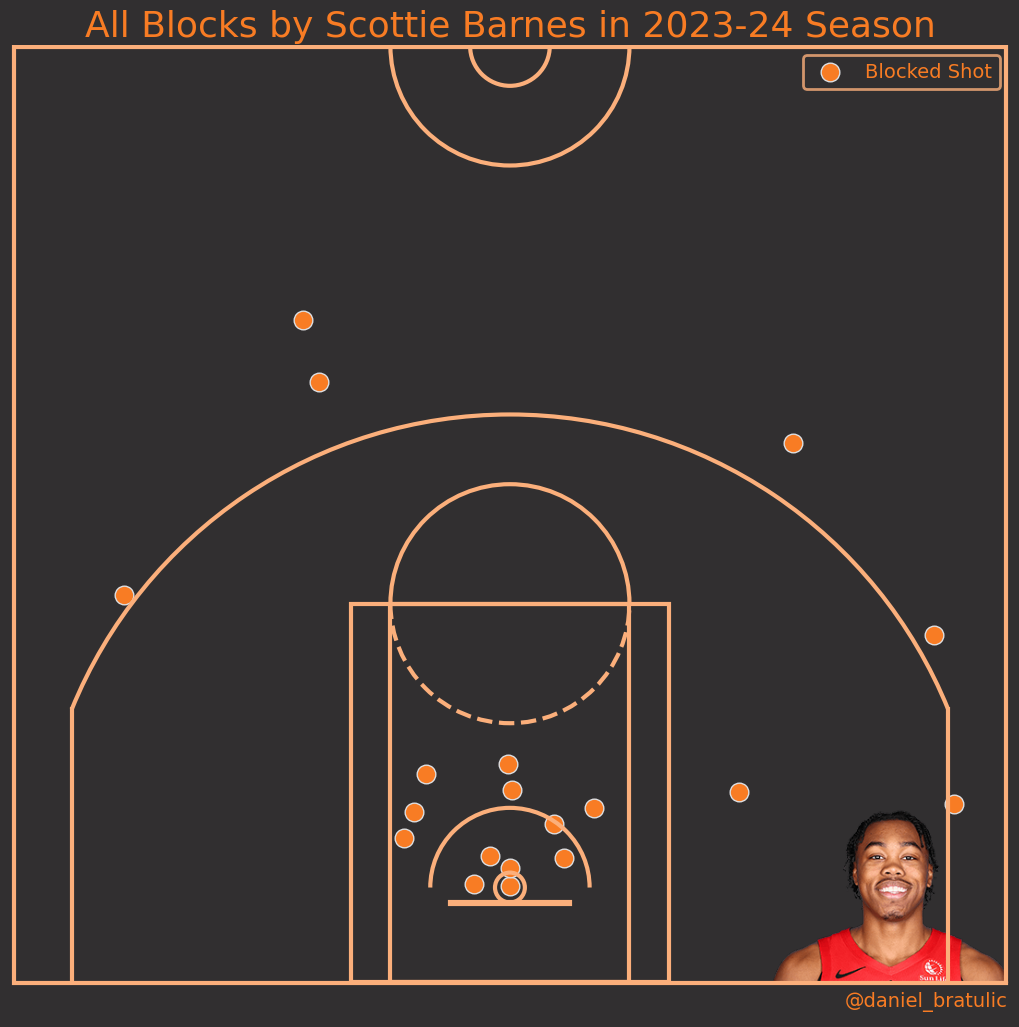

In [82]:
barnes_blocks = blocks.loc[blocks.PLAYER3_NAME == 'Scottie Barnes']

team_id = barnes_blocks.PLAYER3_TEAM_ID.iloc[0]
player_id = barnes_blocks.PLAYER3_ID.iloc[0]

plot_raw_shotchart(data_frame=barnes_blocks, title='All Blocks by Scottie Barnes in 2023-24 Season', team_id=team_id, player_id=player_id)

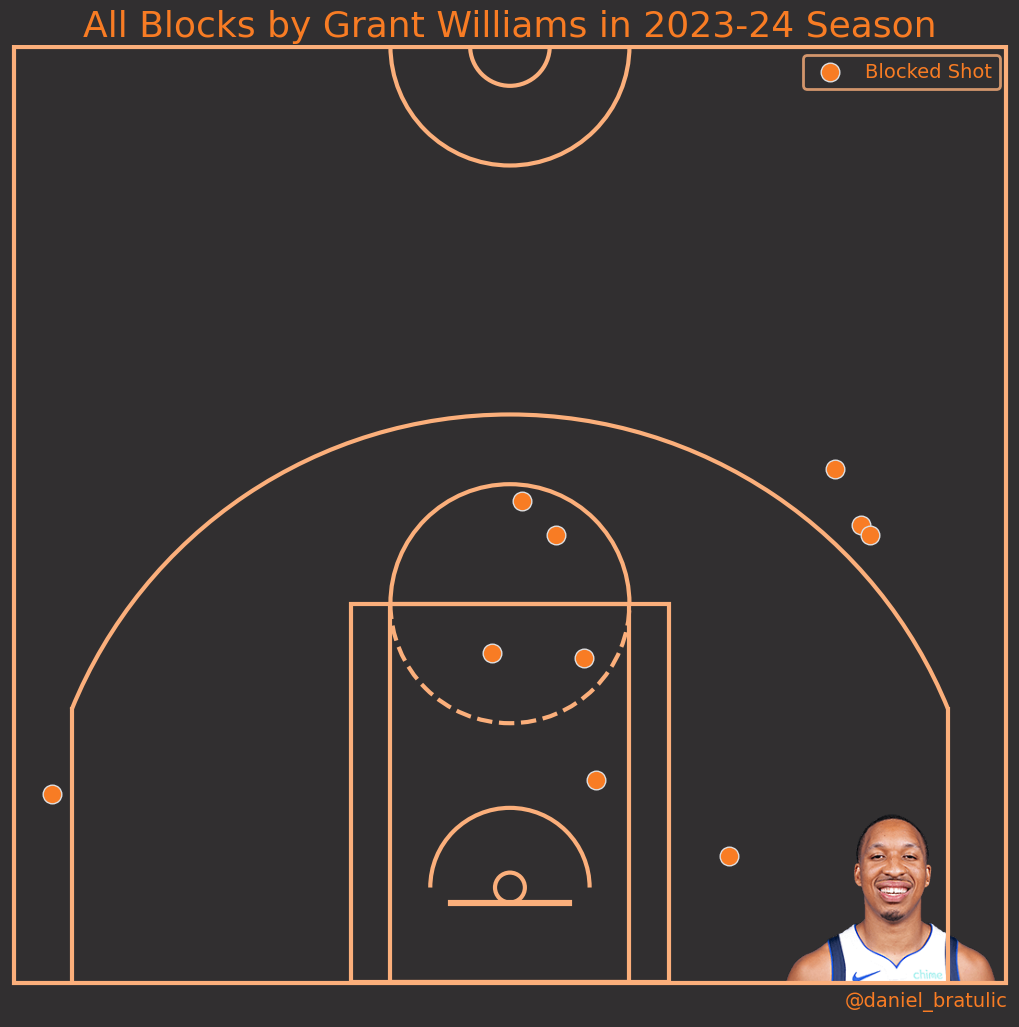

In [84]:
player_name = 'Grant Williams'
player_blocks = blocks.loc[blocks.PLAYER3_NAME == player_name]

team_id = player_blocks.PLAYER3_TEAM_ID.iloc[0]
player_id = player_blocks.PLAYER3_ID.iloc[0]

plot_raw_shotchart(data_frame=player_blocks, title=f'All Blocks by {player_name} in 2023-24 Season', team_id=team_id, player_id=player_id)

## Scottie look back

In [75]:
last_pbp_df = pd.read_csv('pbp_data/2022-23.csv')
last_pbp_df = last_pbp_df.fillna({
    "HOMEDESCRIPTION": "",
    "NEUTRALDESCRIPTION": "",
    "VISITORDESCRIPTION": ""
})
last_pbp_df.loc[:, 'GAME_ID'] = [f"00{item}" for item in last_pbp_df.GAME_ID.astype(str)]

In [76]:
last_shots_df = ShotChartDetail(team_id=0, player_id=0, season_nullable='2022-23', context_measure_simple='FGA').get_data_frames()[0]

In [77]:
last_merged_df = pd.merge(left=last_shots_df, right=last_pbp_df, left_on=['GAME_ID', 'GAME_EVENT_ID'], right_on=['GAME_ID', 'EVENTNUM'])

last_blocks = last_merged_df.loc[(last_merged_df.EVENTMSGTYPE == 2) & (last_merged_df.PLAYER3_ID != 0)]

In [81]:
last_blocks.loc[last_blocks.SHOT_ZONE_BASIC.isin(['Mid-Range','Above the Break 3', 'Left Corner 3', 'Right Corner 3',])].groupby(['PLAYER3_NAME']).SHOT_ATTEMPTED_FLAG.sum().to_frame().reset_index().sort_values(by='SHOT_ATTEMPTED_FLAG', ascending=False).iloc[:25]

,PLAYER3_NAME,SHOT_ATTEMPTED_FLAG
26,Bol Bol,29
32,Bruce Brown,18
108,Herbert Jones,17
221,Matisse Thybulle,17
44,Chris Boucher,16
281,Shai Gilgeous-Alexander,15
259,Patrick Beverley,15
88,Draymond Green,14
103,Grant Williams,13
260,Patrick Williams,13
